In [1]:
using MLDatasets
using ImageCore
using LinearAlgebra
using PyPlot
using Random
using Statistics
using Printf
using Quaternions
using JLD2, FileIO
using ProgressMeter
include("HyperRPNNs.jl")
include("InverseCmatrix.jl")
rng = MersenneTwister(1234);

In [2]:
function cifar2gray(x)
    return round.(Int,255*(0.2989*x[:,:,1,1] + 0.5870*x[:,:,2,1]+ 0.1140*x[:,:,3,1]))
end

function gray2multistate(x,K)
    zsize = size(x)
    z = exp.(2.0*pi*x*im/K)[:]
    return hcat(real.(z),imag.(z)), zsize
end

function multistate2gray(y,K,ysize)
    z = y[:,1]+y[:,2]*im
    return reshape(Array{Int64}((round.(K*(2*pi.+angle.(z))./(2*pi))).%K),ysize)
end

function imnoise(img,noise_std = 0.1)
    return clamp.(img + noise_std*randn(rng, Float64, size(img)),0,1)
end

imnoise (generic function with 2 methods)

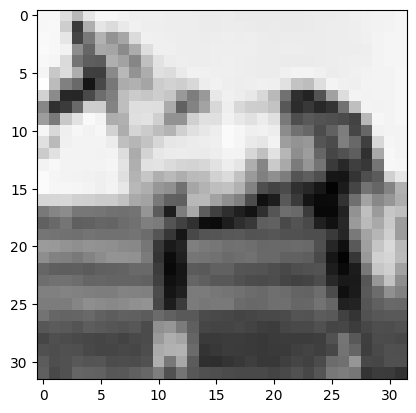

In [3]:
# load full training set
train_x, train_y = CIFAR10.traindata();
# Select the fundamental memory
P = 200
indFM = randperm(rng, size(train_x)[4])[1:P];
# Select one image from the fundamental memory set
iFMS=200
imgx = cifar2gray(train_x[:,:,:,indFM[iFMS]])
imshow(transpose(imgx),cmap=get_cmap("gray"), vmin=0, vmax=255)
# title("Original (undistorted) image")
savefig("CIFAR_Original.eps", bbox_inches="tight")
savefig("CIFAR_Original.pdf", bbox_inches="tight")

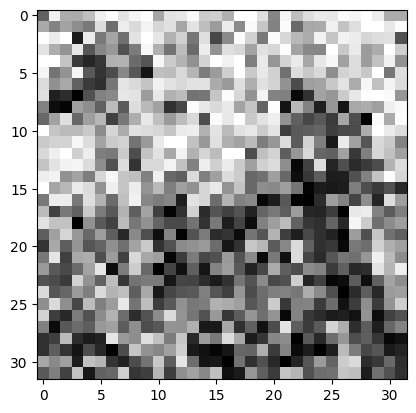

In [4]:
imgxr = cifar2gray(imnoise(train_x[:,:,:,indFM[iFMS]],100/255))
imshow(transpose(imgxr),cmap=get_cmap("gray"), vmin=0, vmax=255)
# title("Corrupted image")
savefig("CIFAR_Corrupted.eps", bbox_inches="tight")
savefig("CIFAR_Corrupted.pdf", bbox_inches="tight")

In [5]:
K = 256
x, xsize = gray2multistate(imgxr,K)
print(size(x))

(1024, 2)

In [6]:
# Complex-valued Multistate RPNN
N = 32*32
#alpha = 20/(N)
alpha = 20
beta = -20

U = Array{Real}(undef,N,2,P)
for i=1:P
    uc, usize = gray2multistate(cifar2gray(train_x[:,:,:,indFM[i]]),K)
    U[:,:,i] = uc
end

print(size(U))

(1024, 2, 200)

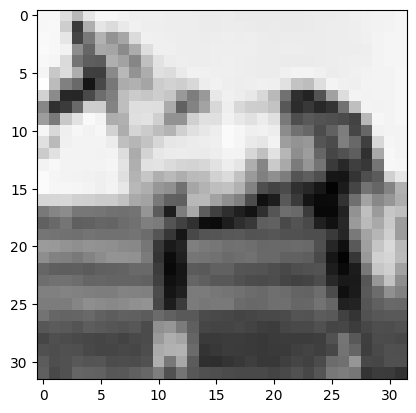

MSE = 0.0

In [7]:
y, Energy = HyperRPNNs.Sync(HyperRPNNs.LambdaInner,[1,1],HyperRPNNs.csign,K,U,x,alpha,beta)
imgy = multistate2gray(y,K,xsize)

print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(transpose(imgy),cmap=get_cmap("gray"), vmin=0, vmax=255)
#title("Complex-valued multistate RPNN (Synchronous)")
savefig("CIFAR_CvMultistateRPNN_Synchronous.pdf", bbox_inches="tight")

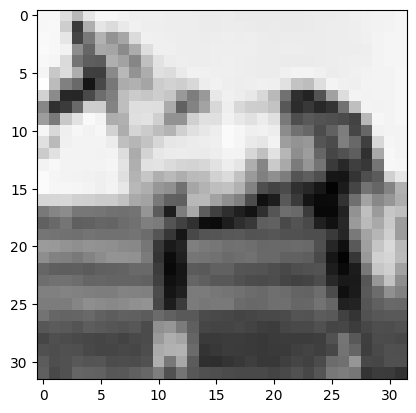

MSE = 0.0

In [16]:
y, Energy = HyperRPNNs.Seq(HyperRPNNs.LambdaInner,[1,1],HyperRPNNs.csign,K,U,x,alpha,beta)
imgy = multistate2gray(y,K,xsize)

print("MSE = ",sqrt(sum((imgx-imgy).^2)/N))
imshow(transpose(imgy),cmap=get_cmap("gray"), vmin=0, vmax=255)
#title("Complex-valued multistate RPNN (Synchronous)")
savefig("CIFAR_CvMultistateRPNN_Asynchronous.pdf", bbox_inches="tight")